In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import language_tool_python
import spacy
import copy
import json
import os
import re
import torch
from sklearn.utils import resample
import itertools
from functools import reduce
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import (
    AutoModelForSequenceClassification,
    AutoModel,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EvalPrediction
)
from transformers import AutoTokenizer, BertForSequenceClassification
from functions import preprocess_tweet,replace_emoji,lemmatize_text,remove_stops,analyze_sentiment,create_tokenize_function
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
tool = language_tool_python.LanguageTool('pl')

## Introduction


* The following code aims at using pretrained polish BERT models for tweet classifications. 
* Dataset has been labeled to classify all netrual/not relevant tweets as neutral.
* This allows for filtering out noise - tweets that aren't aimed at specific company.
* Models used were chose based on the KLEJ bechmark t(https://klejbenchmark.com/leaderboard/).

### Preparing training dataset

In [5]:
dataset_1 = pd.read_csv('TrainingData/annotation_dataset - general_label.csv',index_col=0)
dataset_2 = pd.read_csv('TrainingData/annotation_dataset - annotation_second_round_labeled.csv',index_col=0)

dataset_1 = dataset_1[['text','Overall']]
dataset_1 =  dataset_1.rename(columns={'Overall':'labels'})

dataset_2 = dataset_2[['text','label']]
dataset_2 =  dataset_2.rename(columns={'label':'labels'})

In [6]:
dataset_labeled = pd.concat([dataset_1,dataset_2],axis=0)

dataset_labeled['labels'] = dataset_labeled['labels'] + 1

dataset_labeled = dataset_labeled.dropna()
dataset_labeled = dataset_labeled.drop_duplicates(subset='text')

dataset_labeled['labels'] = dataset_labeled['labels'].astype(int)

##### Training dataset is imbalanced what will be addressed in the later stage of the analysis. 

<Axes: xlabel='labels'>

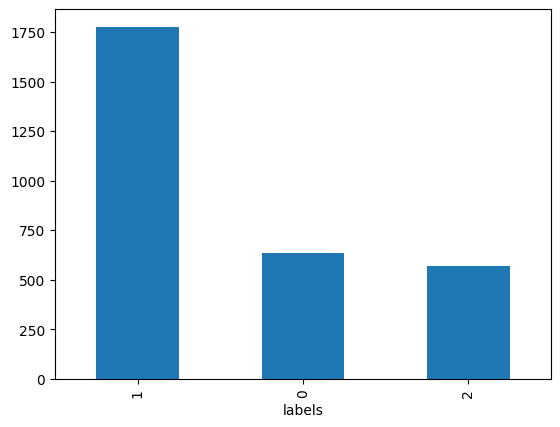

In [7]:
count = dataset_labeled['labels'].value_counts()
count.plot(kind='bar')

Max length will be set as 128. It covers more than 95% of observations

In [8]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tweet_lengths = [len(tokenizer.tokenize(tweet)) for tweet in dataset_labeled["text"]]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

In [9]:
print(f"95th percentile: {np.percentile(tweet_lengths, 95)}")  
print(f"Max tokens: {max(tweet_lengths)}")

95th percentile: 86.84999999999991
Max tokens: 358


# Evaluating Text Preprocessing Strategies for BERT Classification


To evaluate the impact of different text preprocessing techniques on BERT model performance using a systematic comparison approach.

#### Methodology
A baseline BERT model with default parameters was trained on each preprocessed version of the datasets. Due to class imbalance and the focus on positive/negative classification, the F1 score serves as the primary evaluation metric.

#### Preprocessing Strategies
The first part was training the model with different basic preprocessing strategies.
Then we evaluated six distinct preprocessing approaches, incrementally adding complexity to assess the impact of each step:

1. Raw text without any preprocessing
2. Removal of non-textual characters
3. Conversion of emojis to corresponding text + Removal of non-textual characters
4. Removal of non-textual characters + Spelling correction
5. Removal of non-textual characters + Spelling correction + Lemmatization
6. Removal of non-textual characters + Spelling correction + Lemmatization + Stopword removal

Model performance is evaluated using the F1 score, which provides a balanced measure of precision and recall, particularly important for our imbalanced dataset classification task.

In [10]:
tested_models = {}
tested_models['ROBERT'] = "sdadas/polish-roberta-base-v2"
tested_models['HERBERT']  = "allegro/herbert-base-cased"
tested_models['POLBERT']  = "dkleczek/bert-base-polish-cased-v1"

In [11]:
def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+|#\w+', ' ', tweet)
    tweet = re.sub(r'\$\w+', ' ', tweet)
    # Replace underscores with space
    tweet = re.sub(r'_', ' ', tweet)
    # Changed \w to use explicit character ranges instead
    tweet = re.sub(r'[^a-zA-ZĄąĆćĘęŁłŃńÓóŚśŹźŻż0-9\s?!]', ' ', tweet)
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [12]:
#Removing http
def preprocess_tweet_https(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    return tweet

#Removing hashtags
def preprocess_tweet_hashtag(tweet):
    tweet = re.sub(r'#\w+', ' ', tweet)
    return tweet

#Removing mentions
def preprocess_tweet_mention(tweet):
    tweet = re.sub(r'@\w+', ' ', tweet)
    return tweet

#Removing cashtag
def preprocess_tweet_cashtag(tweet):
    tweet = re.sub(r'\$\w+', ' ', tweet)
    return tweet

#Removing all charatcters except polish letter and ? !
def preprocess_tweet_text(tweet):
    tweet = re.sub(r'[^a-zA-ZĄąĆćĘęŁłŃńÓóŚśŹźŻż0-9\s?!]', ' ', tweet)
    return tweet

#Removing repeated letters
def preprocess_tweet_rep(tweet):
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    return tweet

#Removing white spaces
def preprocess_tweet_norm(tweet):
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

#Normalizing caps
def preprocess_caps(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'(^|[.!?]\s+)(\w)', lambda m: m.group(1) + m.group(2).upper(), tweet)
    return tweet

def preprocess_tco(tweet):
    return re.sub(r"https?://t\.co/\S+", "", tweet).strip()

In [13]:
def apply_transformations(df, transformations, name):
    """Apply a sequence of transformations to the dataframe's text column"""
    processed_df = reduce(
        lambda acc, func: acc.assign(text=acc['text'].apply(func)).drop_duplicates(subset='text'),
        transformations,
        copy.deepcopy(df)
    )
    processed_df.to_csv(fr'TrainingData/processed_data_{name}.csv')
    return processed_df

In [14]:
# Processing pipelines
strategies_processing_pipelines = {
    'No_processing': [],
    'No_processing_emoji': [
        replace_emoji
    ],
    'No_processing_spelling': [
        tool.correct
    ],
    'No_processing_spelling_lem': [
        tool.correct,
        lemmatize_text
    ],
    'No_processing_spelling_lem_sp': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text,
        remove_stops
    ],
    'Basic_processing': [
        preprocess_tweet
    ],
    'Basic_processing_emoji': [
        preprocess_tweet,
        replace_emoji
    ],
    'Basic_processing_spelling': [
        preprocess_tweet,
        tool.correct
    ],
    'Basic_processing_spelling_lem': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text
    ],
    'Basic_processing_spelling_lem_SP': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text,
        remove_stops
    ]
}

basic_processing_pipelines = {
    'No_processing': [],
    'No_processing_http': [
        preprocess_tweet_https
    ],
    'No_processing_hashtag': [
        preprocess_tweet_hashtag
    ],
    'No_processing_mention': [
        preprocess_tweet_mention
    ],
    'No_processing_cashtag': [
        preprocess_tweet_cashtag
    ],
    'No_processing__text': [
        preprocess_tweet_text
    ],
    'No_processing__rep': [
        preprocess_tweet_rep
    ],
    'No_processing_norm': [
        preprocess_tweet_norm
    ],
    'No_processing_caps': [
        preprocess_caps
    ]
}

In [15]:
# Process all variants
datasets_basic = {
    name: apply_transformations(dataset_labeled, pipeline,name = name)
    for name, pipeline in basic_processing_pipelines.items()}

In [ ]:
datasets_strategies = {
    name: apply_transformations(dataset_labeled, pipeline, name = name)
    for name, pipeline in strategies_processing_pipelines.items()}

In [ ]:
datasets = datasets_basic
model = tested_models['dkleczek/bert-base-polish-cased-v1']

In [54]:
tokenized_datasets = {}
for key, df in datasets.items():
    # First split the data before balancing
    dataset = Dataset.from_pandas(df)
    dataset = dataset.remove_columns('__index_level_0__')
    train_test = dataset.train_test_split(test_size=0.3, seed=16)
    
    # Convert to pandas to balance only training data
    train_df = train_test['train'].to_pandas()
    test_df = train_test['test'].to_pandas()
    
    # Balance only training data
    #balanced_train_df = balance_text_data(train_df)
    #balanced_train_dataset = Dataset.from_pandas(balanced_train_df)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    # Tokenize both datasets
    tokenizer = AutoTokenizer.from_pretrained(model)
    
    # Tokenize training data
    tokenized_train = train_dataset.map(
        lambda examples: tokenizer(examples["text"], 
                                 truncation=True, 
                                 padding="max_length",
                                 max_length=128),
        batched=True,
        remove_columns=['text']
    )
    
    # Tokenize test data
    tokenized_test = test_dataset.map(
        lambda examples: tokenizer(examples["text"], 
                                 truncation=True, 
                                 padding="max_length",
                                 max_length=128),
        batched=True,
        remove_columns=['text']
    )
    
    # Set format for PyTorch
    tokenized_train.set_format("torch", 
                              columns=["input_ids", 
                                      "attention_mask", 
                                      "labels"])
    tokenized_test.set_format("torch", 
                             columns=["input_ids", 
                                     "attention_mask", 
                                     "labels"])
    
    # Combine into DatasetDict
    tokenized_datasets[key] = DatasetDict({
        'train': tokenized_train,
        'test': tokenized_test
    })

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

In [ ]:
def train_and_evaluate(key, tokenized_dataset, base_model_name):

    # Reload model for each run to reset weights
    model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=3)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{key}_{base_model_name}",
        num_train_epochs=4,
        per_device_train_batch_size=4,  
        per_device_eval_batch_size=32,
        warmup_ratio=0.05,
        weight_decay=0.01,
        learning_rate=2e-5,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro", 
        greater_is_better=True,
        seed=45,
        fp16=torch.cuda.is_available(),
        report_to="none",
        logging_steps=25,
        gradient_accumulation_steps=2,
        max_grad_norm=15.0,
        save_total_limit=2,  # Keep only last 2 checkpoints
        group_by_length=True,
    )

    # Initialize custom trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()
    
    return eval_results

In [ ]:
# Main comparison loop
results = []

for key, tokenized_dataset in tokenized_datasets.items():
    try:
        print(f"\n{'='*40}")
        print(f"Testing preprocessing variant: {key}")
        print(f"{'='*40}")
        print(f'Training model: {model}')
        metrics = train_and_evaluate(key, tokenized_dataset,model)
        
        results.append({
            "model":model,
            "preprocessing": key,
            "accuracy": metrics["eval_accuracy"],
            "macro_f1": metrics["eval_f1_macro"],
            "weighted_f1": metrics["eval_f1_weighted"],
            "neutral_f1": metrics["eval_f1_0"],
            "positive_f1": metrics["eval_f1_1"],
            "negative_f1": metrics["eval_f1_2"],
            "epochs": metrics["epoch"]
        })

        print(results)
        
    except Exception as e:
        print(f"Error with variant {key}: {str(e)}")

# Save results
results_df = pd.DataFrame(results)

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(rf"preprocessing_comparison_general_label_preprocessing_{model}.csv"), exist_ok=True)

# Now save the CSV
results_df.to_csv(rf"preprocessing_comparison_general_label_preprocessing_{model}.csv", index=False)
print("\nComparison saved to preprocessing_comparison.csv")

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca


Testing preprocessing variant: No_processing
Training model: allegro/herbert-base-cased


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

{'loss': 1.0584, 'grad_norm': 7.579248428344727, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [04:06<00:07,  1.41s/it]  

{'loss': 0.9442, 'grad_norm': 5.10402774810791, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [04:42<00:07,  1.41s/it]  

{'loss': 0.9708, 'grad_norm': 8.393890380859375, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [05:18<00:07,  1.41s/it]   

{'loss': 0.9923, 'grad_norm': 6.954557418823242, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [05:53<00:07,  1.41s/it]   

{'loss': 0.9422, 'grad_norm': 15.152691841125488, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [06:29<00:07,  1.41s/it]   

{'loss': 0.8886, 'grad_norm': 7.321695327758789, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [07:05<00:07,  1.41s/it]   

{'loss': 0.7993, 'grad_norm': 24.327877044677734, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [07:41<00:07,  1.41s/it]   

{'loss': 0.7987, 'grad_norm': 13.519432067871094, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [08:17<00:07,  1.41s/it]   

{'loss': 0.7334, 'grad_norm': 16.466838836669922, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [08:53<00:07,  1.41s/it]   

{'loss': 0.7184, 'grad_norm': 60.5189208984375, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [09:44<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.7776700258255005, 'eval_accuracy': 0.6462053571428571, 'eval_f1_macro': 0.553596193022971, 'eval_f1_weighted': 0.6324176569645957, 'eval_f1_0': 0.5923217550274223, 'eval_f1_1': 0.7455968688845401, 'eval_f1_2': 0.32286995515695066, 'eval_runtime': 34.9347, 'eval_samples_per_second': 25.648, 'eval_steps_per_second': 0.801, 'epoch': 1.0}


Model weights saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-261\model.safetensors
Deleting older checkpoint [results_No_processing_allegro\herbert-base-cased\checkpoint-895] due to args.save_total_limit

 74%|███████▎  | 14/19 [10:14<00:07,  1.41s/it]   

{'loss': 0.827, 'grad_norm': 6.911230087280273, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [10:50<00:07,  1.41s/it]   

{'loss': 0.6914, 'grad_norm': 13.97821044921875, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [11:26<00:07,  1.41s/it]   

{'loss': 0.66, 'grad_norm': 9.693144798278809, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [12:02<00:07,  1.41s/it]   

{'loss': 0.5136, 'grad_norm': 22.930253982543945, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [12:38<00:07,  1.41s/it]   

{'loss': 0.6434, 'grad_norm': 16.391626358032227, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [13:14<00:07,  1.41s/it]   

{'loss': 0.5813, 'grad_norm': 11.901056289672852, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [13:49<00:07,  1.41s/it]   

{'loss': 0.644, 'grad_norm': 6.371689796447754, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [14:25<00:07,  1.41s/it]   

{'loss': 0.5784, 'grad_norm': 11.024168968200684, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [15:01<00:07,  1.41s/it]   

{'loss': 0.6552, 'grad_norm': 16.798118591308594, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [15:37<00:07,  1.41s/it]   

{'loss': 0.5794, 'grad_norm': 11.008252143859863, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [16:44<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.6723803877830505, 'eval_accuracy': 0.7220982142857143, 'eval_f1_macro': 0.6434824533464543, 'eval_f1_weighted': 0.7075016795998206, 'eval_f1_0': 0.6506666666666666, 'eval_f1_1': 0.8006932409012132, 'eval_f1_2': 0.4790874524714829, 'eval_runtime': 34.9184, 'eval_samples_per_second': 25.66, 'eval_steps_per_second': 0.802, 'epoch': 2.0}


Model weights saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-522\model.safetensors
Deleting older checkpoint [results_No_processing_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [16:58<00:07,  1.41s/it]     

{'loss': 0.5235, 'grad_norm': 9.715731620788574, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [17:34<00:07,  1.41s/it]   

{'loss': 0.3691, 'grad_norm': 10.675468444824219, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [18:09<00:07,  1.41s/it]   

{'loss': 0.3971, 'grad_norm': 20.19683265686035, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [18:45<00:07,  1.41s/it]   

{'loss': 0.39, 'grad_norm': 13.456282615661621, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [19:20<00:07,  1.41s/it]   

{'loss': 0.4194, 'grad_norm': 15.577534675598145, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [19:55<00:07,  1.41s/it]   

{'loss': 0.3213, 'grad_norm': 11.546286582946777, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [20:30<00:07,  1.41s/it]   

{'loss': 0.346, 'grad_norm': 2.032898426055908, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [21:06<00:07,  1.41s/it]   

{'loss': 0.4195, 'grad_norm': 20.23858642578125, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [21:41<00:07,  1.41s/it]   

{'loss': 0.3751, 'grad_norm': 31.843387603759766, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [22:16<00:07,  1.41s/it]   

{'loss': 0.3761, 'grad_norm': 12.364965438842773, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [22:52<00:07,  1.41s/it]   

{'loss': 0.3205, 'grad_norm': 32.27821731567383, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [23:37<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7459568381309509, 'eval_accuracy': 0.7276785714285714, 'eval_f1_macro': 0.6841980396779271, 'eval_f1_weighted': 0.7314420046522663, 'eval_f1_0': 0.6788511749347258, 'eval_f1_1': 0.8007699711260827, 'eval_f1_2': 0.572972972972973, 'eval_runtime': 34.1339, 'eval_samples_per_second': 26.25, 'eval_steps_per_second': 0.82, 'epoch': 3.0}


Model weights saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

 74%|███████▎  | 14/19 [24:11<00:07,  1.41s/it]   

{'loss': 0.3095, 'grad_norm': 23.603229522705078, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [24:49<00:07,  1.41s/it]   

{'loss': 0.2217, 'grad_norm': 22.091856002807617, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [25:25<00:07,  1.41s/it]   

{'loss': 0.2742, 'grad_norm': 37.71381759643555, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [26:00<00:07,  1.41s/it]   

{'loss': 0.2497, 'grad_norm': 4.561873912811279, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [26:35<00:07,  1.41s/it]   

{'loss': 0.1486, 'grad_norm': 16.305206298828125, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [27:10<00:07,  1.41s/it]   

{'loss': 0.1512, 'grad_norm': 11.46944522857666, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [27:46<00:07,  1.41s/it]   

{'loss': 0.1938, 'grad_norm': 11.111149787902832, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [28:21<00:07,  1.41s/it]   

{'loss': 0.2191, 'grad_norm': 29.15425682067871, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [28:56<00:07,  1.41s/it]    

{'loss': 0.1524, 'grad_norm': 6.459968090057373, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [29:32<00:07,  1.41s/it]    

{'loss': 0.1992, 'grad_norm': 7.665366172790527, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing_allegro\herbert-base-cased\checkpoint-1044] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [30:44<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.7916117310523987, 'eval_accuracy': 0.7276785714285714, 'eval_f1_macro': 0.6779268832998712, 'eval_f1_weighted': 0.7270012800846715, 'eval_f1_0': 0.6896551724137931, 'eval_f1_1': 0.7981132075471699, 'eval_f1_2': 0.5460122699386503, 'eval_runtime': 35.0584, 'eval_samples_per_second': 25.557, 'eval_steps_per_second': 0.799, 'epoch': 4.0}


Model weights saved in ./results_No_processing_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing_allegro\herbert-base-cased\checkpoint-1044] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing_allegro/herbert-base-cased\checkpoint-783 (score: 0.6841980396779271).

100%|██████████| 1044/1044 [28:07<00:00,  1.62s/it]

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32


{'train_runtime': 1687.3308, 'train_samples_per_second': 4.95, 'train_steps_per_second': 0.619, 'train_loss': 0.5229683376820151, 'epoch': 4.0}


100%|██████████| 28/28 [00:33<00:00,  1.18s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}]

Testing preprocessing variant: No_processing_http
Training model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 0.9616, 'grad_norm': 6.355753421783447, 'learning_rate': 9.615384615384616e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [32:49<00:07,  1.41s/it]  

{'loss': 0.9485, 'grad_norm': 4.766526699066162, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [33:25<00:07,  1.41s/it]  

{'loss': 0.8903, 'grad_norm': 7.058584213256836, 'learning_rate': 1.953441295546559e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [34:01<00:07,  1.41s/it]   

{'loss': 0.9098, 'grad_norm': 13.655077934265137, 'learning_rate': 1.9028340080971662e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [34:36<00:07,  1.41s/it]   

{'loss': 0.9277, 'grad_norm': 8.609986305236816, 'learning_rate': 1.8522267206477735e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [35:12<00:07,  1.41s/it]   

{'loss': 0.8783, 'grad_norm': 51.34620666503906, 'learning_rate': 1.801619433198381e-05, 'epoch': 0.58}



 74%|███████▎  | 14/19 [35:47<00:07,  1.41s/it]   

{'loss': 0.8503, 'grad_norm': 8.405860900878906, 'learning_rate': 1.751012145748988e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [36:23<00:07,  1.41s/it]   

{'loss': 0.8243, 'grad_norm': 19.96824073791504, 'learning_rate': 1.7004048582995952e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [36:58<00:07,  1.41s/it]   

{'loss': 0.7017, 'grad_norm': 13.482708930969238, 'learning_rate': 1.6497975708502025e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [37:34<00:07,  1.41s/it]   

{'loss': 0.7038, 'grad_norm': 13.658818244934082, 'learning_rate': 1.59919028340081e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 893
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [38:23<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-260
Configuration saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-260\config.json


{'eval_loss': 0.7645179629325867, 'eval_accuracy': 0.671892497200448, 'eval_f1_macro': 0.5817345999560392, 'eval_f1_weighted': 0.6482185946193219, 'eval_f1_0': 0.5281899109792285, 'eval_f1_1': 0.7725694444444444, 'eval_f1_2': 0.4444444444444444, 'eval_runtime': 34.1687, 'eval_samples_per_second': 26.135, 'eval_steps_per_second': 0.819, 'epoch': 1.0}


Model weights saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-260\model.safetensors

 74%|███████▎  | 14/19 [38:54<00:07,  1.41s/it]   

{'loss': 0.6824, 'grad_norm': 9.513500213623047, 'learning_rate': 1.5485829959514172e-05, 'epoch': 1.06}



 74%|███████▎  | 14/19 [39:29<00:07,  1.41s/it]   

{'loss': 0.507, 'grad_norm': 54.77683639526367, 'learning_rate': 1.4979757085020243e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [40:05<00:07,  1.41s/it]   

{'loss': 0.5724, 'grad_norm': 24.30030632019043, 'learning_rate': 1.4473684210526317e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [40:40<00:07,  1.41s/it]   

{'loss': 0.573, 'grad_norm': 12.433663368225098, 'learning_rate': 1.396761133603239e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [41:15<00:07,  1.41s/it]   

{'loss': 0.6753, 'grad_norm': 18.19736671447754, 'learning_rate': 1.3461538461538463e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [41:50<00:07,  1.41s/it]   

{'loss': 0.5917, 'grad_norm': 18.045381546020508, 'learning_rate': 1.2955465587044535e-05, 'epoch': 1.54}



 74%|███████▎  | 14/19 [42:26<00:07,  1.41s/it]   

{'loss': 0.6298, 'grad_norm': 11.198561668395996, 'learning_rate': 1.2449392712550608e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [43:01<00:07,  1.41s/it]   

{'loss': 0.5786, 'grad_norm': 14.74775218963623, 'learning_rate': 1.1943319838056682e-05, 'epoch': 1.73}



 74%|███████▎  | 14/19 [43:36<00:07,  1.41s/it]   

{'loss': 0.6177, 'grad_norm': 17.125152587890625, 'learning_rate': 1.1437246963562753e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [44:11<00:07,  1.41s/it]   

{'loss': 0.5537, 'grad_norm': 16.752073287963867, 'learning_rate': 1.0931174089068828e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 893
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [45:15<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-521
Configuration saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-521\config.json


{'eval_loss': 0.7256925702095032, 'eval_accuracy': 0.6931690929451287, 'eval_f1_macro': 0.6639107915728655, 'eval_f1_weighted': 0.696372811943066, 'eval_f1_0': 0.6318407960199005, 'eval_f1_1': 0.7574819401444789, 'eval_f1_2': 0.6024096385542169, 'eval_runtime': 34.3783, 'eval_samples_per_second': 25.976, 'eval_steps_per_second': 0.814, 'epoch': 2.0}


Model weights saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-521\model.safetensors
Deleting older checkpoint [results_No_processing_http_allegro\herbert-base-cased\checkpoint-260] due to args.save_total_limit

 74%|███████▎  | 14/19 [45:32<00:07,  1.41s/it]   

{'loss': 0.5574, 'grad_norm': 8.08380126953125, 'learning_rate': 1.04251012145749e-05, 'epoch': 2.02}



 74%|███████▎  | 14/19 [46:08<00:07,  1.41s/it]   

{'loss': 0.3664, 'grad_norm': 15.664647102355957, 'learning_rate': 9.919028340080973e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [46:43<00:07,  1.41s/it]   

{'loss': 0.2952, 'grad_norm': 12.704466819763184, 'learning_rate': 9.412955465587045e-06, 'epoch': 2.21}



 74%|███████▎  | 14/19 [47:19<00:07,  1.41s/it]   

{'loss': 0.3724, 'grad_norm': 25.150978088378906, 'learning_rate': 8.906882591093118e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [47:54<00:07,  1.41s/it]   

{'loss': 0.4083, 'grad_norm': 35.108726501464844, 'learning_rate': 8.400809716599191e-06, 'epoch': 2.4}



 74%|███████▎  | 14/19 [48:30<00:07,  1.41s/it]   

{'loss': 0.3732, 'grad_norm': 17.238574981689453, 'learning_rate': 7.894736842105265e-06, 'epoch': 2.5}



 74%|███████▎  | 14/19 [49:05<00:07,  1.41s/it]   

{'loss': 0.3346, 'grad_norm': 16.509851455688477, 'learning_rate': 7.388663967611337e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [49:41<00:07,  1.41s/it]   

{'loss': 0.3158, 'grad_norm': 24.231685638427734, 'learning_rate': 6.882591093117409e-06, 'epoch': 2.69}



 74%|███████▎  | 14/19 [50:16<00:07,  1.41s/it]   

{'loss': 0.3655, 'grad_norm': 25.443756103515625, 'learning_rate': 6.376518218623482e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [50:52<00:07,  1.41s/it]   

{'loss': 0.3674, 'grad_norm': 24.787973403930664, 'learning_rate': 5.870445344129555e-06, 'epoch': 2.88}



 74%|███████▎  | 14/19 [51:27<00:07,  1.41s/it]   

{'loss': 0.2793, 'grad_norm': 23.90633201599121, 'learning_rate': 5.364372469635628e-06, 'epoch': 2.98}



***** Running Evaluation *****
  Num examples = 893
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [52:10<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-781
Configuration saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-781\config.json


{'eval_loss': 0.7923822402954102, 'eval_accuracy': 0.7077267637178052, 'eval_f1_macro': 0.6624497628807974, 'eval_f1_weighted': 0.7037631607750735, 'eval_f1_0': 0.6205128205128205, 'eval_f1_1': 0.7816091954022989, 'eval_f1_2': 0.5852272727272727, 'eval_runtime': 34.3799, 'eval_samples_per_second': 25.974, 'eval_steps_per_second': 0.814, 'epoch': 3.0}


Model weights saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-781\model.safetensors
Deleting older checkpoint [results_No_processing_http_allegro\herbert-base-cased\checkpoint-288] due to args.save_total_limit

 74%|███████▎  | 14/19 [52:47<00:07,  1.41s/it]   

{'loss': 0.1905, 'grad_norm': 58.16408920288086, 'learning_rate': 4.8582995951417e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [53:22<00:07,  1.41s/it]   

{'loss': 0.2189, 'grad_norm': 4.201410293579102, 'learning_rate': 4.3522267206477735e-06, 'epoch': 3.17}



 74%|███████▎  | 14/19 [53:57<00:07,  1.41s/it]   

{'loss': 0.1727, 'grad_norm': 16.82158660888672, 'learning_rate': 3.846153846153847e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [54:32<00:07,  1.41s/it]   

{'loss': 0.2266, 'grad_norm': 12.685111045837402, 'learning_rate': 3.3400809716599193e-06, 'epoch': 3.36}



 74%|███████▎  | 14/19 [55:07<00:07,  1.41s/it]   

{'loss': 0.201, 'grad_norm': 15.579649925231934, 'learning_rate': 2.834008097165992e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [55:42<00:07,  1.41s/it]   

{'loss': 0.2217, 'grad_norm': 27.29026222229004, 'learning_rate': 2.327935222672065e-06, 'epoch': 3.55}



 74%|███████▎  | 14/19 [56:17<00:07,  1.41s/it]   

{'loss': 0.2202, 'grad_norm': 21.230392456054688, 'learning_rate': 1.8218623481781379e-06, 'epoch': 3.65}



 74%|███████▎  | 14/19 [56:51<00:07,  1.41s/it]   

{'loss': 0.1855, 'grad_norm': 8.595382690429688, 'learning_rate': 1.3157894736842106e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [57:26<00:07,  1.41s/it]    

{'loss': 0.1353, 'grad_norm': 3.361626625061035, 'learning_rate': 8.097165991902834e-07, 'epoch': 3.84}



 74%|███████▎  | 14/19 [58:01<00:07,  1.41s/it]    

{'loss': 0.222, 'grad_norm': 18.54242515563965, 'learning_rate': 3.0364372469635626e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-1040
Configuration saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-1040\config.json
Model weights saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-1040\model.safetensors
Deleting older checkpoint [results_No_processing_http_allegro\herbert-base-cased\checkpoint-781] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 893
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [59:07<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-1040
Configuration saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-1040\config.json


{'eval_loss': 0.8796806335449219, 'eval_accuracy': 0.7088465845464725, 'eval_f1_macro': 0.6582721266660506, 'eval_f1_weighted': 0.7014778792567007, 'eval_f1_0': 0.6321243523316062, 'eval_f1_1': 0.7817164179104478, 'eval_f1_2': 0.5609756097560976, 'eval_runtime': 34.8536, 'eval_samples_per_second': 25.621, 'eval_steps_per_second': 0.803, 'epoch': 3.99}


Model weights saved in ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-1040\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing_http_allegro/herbert-base-cased\checkpoint-521 (score: 0.6639107915728655).

100%|██████████| 1040/1040 [27:50<00:00,  1.61s/it]

***** Running Evaluation *****
  Num examples = 893
  Batch size = 32


{'train_runtime': 1670.4757, 'train_samples_per_second': 4.985, 'train_steps_per_second': 0.623, 'train_loss': 0.4973429487301753, 'epoch': 3.99}


100%|██████████| 28/28 [00:32<00:00,  1.18s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}]

Testing preprocessing variant: No_processing_hashtag
Training model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 1.2666, 'grad_norm': 9.810128211975098, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [1:01:16<00:07,  1.41s/it]

{'loss': 0.9445, 'grad_norm': 10.379374504089355, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [1:01:51<00:07,  1.41s/it]

{'loss': 0.9843, 'grad_norm': 8.799097061157227, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [1:02:27<00:07,  1.41s/it] 

{'loss': 1.0097, 'grad_norm': 6.557713985443115, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [1:03:02<00:07,  1.41s/it] 

{'loss': 0.9217, 'grad_norm': 13.096837043762207, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [1:03:37<00:07,  1.41s/it] 

{'loss': 0.8672, 'grad_norm': 7.984671115875244, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [1:04:12<00:07,  1.41s/it] 

{'loss': 0.8071, 'grad_norm': 9.807134628295898, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [1:04:47<00:07,  1.41s/it] 

{'loss': 0.7929, 'grad_norm': 17.833309173583984, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [1:05:22<00:07,  1.41s/it] 

{'loss': 0.7948, 'grad_norm': 28.96474838256836, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [1:05:57<00:07,  1.41s/it] 

{'loss': 0.7134, 'grad_norm': 37.10857009887695, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [1:06:48<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.8301162719726562, 'eval_accuracy': 0.6272321428571429, 'eval_f1_macro': 0.5399914382943637, 'eval_f1_weighted': 0.6156561891515763, 'eval_f1_0': 0.564748201438849, 'eval_f1_1': 0.724950884086444, 'eval_f1_2': 0.3302752293577982, 'eval_runtime': 34.8671, 'eval_samples_per_second': 25.698, 'eval_steps_per_second': 0.803, 'epoch': 1.0}


Model weights saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-261\model.safetensors

 74%|███████▎  | 14/19 [1:07:19<00:07,  1.41s/it] 

{'loss': 0.8488, 'grad_norm': 6.546280384063721, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [1:07:55<00:07,  1.41s/it] 

{'loss': 0.6937, 'grad_norm': 15.201605796813965, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [1:08:30<00:07,  1.41s/it] 

{'loss': 0.6469, 'grad_norm': 11.166773796081543, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [1:09:05<00:07,  1.41s/it] 

{'loss': 0.5583, 'grad_norm': 14.214914321899414, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [1:09:41<00:07,  1.41s/it] 

{'loss': 0.6034, 'grad_norm': 30.7203311920166, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [1:10:16<00:07,  1.41s/it] 

{'loss': 0.6254, 'grad_norm': 14.33179759979248, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [1:10:52<00:07,  1.41s/it] 

{'loss': 0.6718, 'grad_norm': 8.148767471313477, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [1:11:27<00:07,  1.41s/it] 

{'loss': 0.6069, 'grad_norm': 8.152971267700195, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [1:12:02<00:07,  1.41s/it] 

{'loss': 0.6152, 'grad_norm': 26.77111053466797, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [1:12:37<00:07,  1.41s/it] 

{'loss': 0.5873, 'grad_norm': 12.964457511901855, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [1:13:43<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.7047405242919922, 'eval_accuracy': 0.7220982142857143, 'eval_f1_macro': 0.6371091178034433, 'eval_f1_weighted': 0.7053113599249208, 'eval_f1_0': 0.6408839779005525, 'eval_f1_1': 0.8047945205479452, 'eval_f1_2': 0.46564885496183206, 'eval_runtime': 34.6702, 'eval_samples_per_second': 25.844, 'eval_steps_per_second': 0.808, 'epoch': 2.0}


Model weights saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-522\model.safetensors

 74%|███████▎  | 14/19 [1:13:58<00:07,  1.41s/it]   

{'loss': 0.5488, 'grad_norm': 16.734477996826172, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [1:14:34<00:07,  1.41s/it] 

{'loss': 0.3828, 'grad_norm': 9.237231254577637, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [1:15:09<00:07,  1.41s/it] 

{'loss': 0.4242, 'grad_norm': 28.2421932220459, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [1:15:44<00:07,  1.41s/it] 

{'loss': 0.3987, 'grad_norm': 23.189632415771484, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [1:16:19<00:07,  1.41s/it] 

{'loss': 0.4216, 'grad_norm': 14.508130073547363, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [1:16:54<00:07,  1.41s/it] 

{'loss': 0.334, 'grad_norm': 18.695423126220703, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [1:17:28<00:07,  1.41s/it] 

{'loss': 0.3746, 'grad_norm': 19.467069625854492, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [1:18:04<00:07,  1.41s/it] 

{'loss': 0.4577, 'grad_norm': 21.100122451782227, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [1:18:39<00:07,  1.41s/it] 

{'loss': 0.3393, 'grad_norm': 27.763952255249023, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [1:19:14<00:07,  1.41s/it] 

{'loss': 0.3543, 'grad_norm': 9.613200187683105, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [1:19:49<00:07,  1.41s/it] 

{'loss': 0.342, 'grad_norm': 18.501638412475586, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [1:20:34<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7330573201179504, 'eval_accuracy': 0.7176339285714286, 'eval_f1_macro': 0.6591304545382598, 'eval_f1_weighted': 0.7137792176789548, 'eval_f1_0': 0.6702127659574468, 'eval_f1_1': 0.7930720145852325, 'eval_f1_2': 0.5141065830721003, 'eval_runtime': 34.1824, 'eval_samples_per_second': 26.212, 'eval_steps_per_second': 0.819, 'epoch': 3.0}


Model weights saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing_hashtag_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [1:21:08<00:07,  1.41s/it] 

{'loss': 0.324, 'grad_norm': 14.029914855957031, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [1:21:43<00:07,  1.41s/it] 

{'loss': 0.2002, 'grad_norm': 8.272696495056152, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [1:22:18<00:07,  1.41s/it] 

{'loss': 0.269, 'grad_norm': 35.78861618041992, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [1:22:53<00:07,  1.41s/it] 

{'loss': 0.2263, 'grad_norm': 14.765359878540039, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [1:23:28<00:07,  1.41s/it] 

{'loss': 0.1716, 'grad_norm': 70.6908950805664, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [1:24:03<00:07,  1.41s/it] 

{'loss': 0.1676, 'grad_norm': 8.2752046585083, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [1:24:38<00:07,  1.41s/it] 

{'loss': 0.2442, 'grad_norm': 22.31203269958496, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [1:25:13<00:07,  1.41s/it] 

{'loss': 0.227, 'grad_norm': 12.892791748046875, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [1:25:48<00:07,  1.41s/it]  

{'loss': 0.1441, 'grad_norm': 19.95402717590332, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [1:26:23<00:07,  1.41s/it]  

{'loss': 0.2131, 'grad_norm': 18.507627487182617, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing_hashtag_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [1:27:35<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.8003533482551575, 'eval_accuracy': 0.7265625, 'eval_f1_macro': 0.6735278066278153, 'eval_f1_weighted': 0.7234917057108134, 'eval_f1_0': 0.6770833333333334, 'eval_f1_1': 0.7963302752293578, 'eval_f1_2': 0.5471698113207547, 'eval_runtime': 35.1529, 'eval_samples_per_second': 25.489, 'eval_steps_per_second': 0.797, 'epoch': 4.0}


Model weights saved in ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing_hashtag_allegro/herbert-base-cased\checkpoint-1044 (score: 0.6735278066278153).

100%|██████████| 1044/1044 [27:40<00:00,  1.59s/it]

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32


{'train_runtime': 1660.3716, 'train_samples_per_second': 5.03, 'train_steps_per_second': 0.629, 'train_loss': 0.535191115063269, 'epoch': 4.0}


100%|██████████| 28/28 [00:33<00:00,  1.21s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_hashtag', 'accuracy': 0.7265625, 'macro_f1': 0.6735278066278153, 'weighted_f1': 0.7234917057108134, 'neutral_f1': 0.6770833333333334, 'positive_f1': 0.7963302752293578, 'negative_f1': 0.5471698113207547, 'epochs': 4.0}]

Testing preprocessing variant: No_processing_mention
Training model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 1.0249, 'grad_norm': 4.894474029541016, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [1:29:33<00:07,  1.41s/it]

{'loss': 0.9915, 'grad_norm': 4.884174346923828, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [1:30:08<00:07,  1.41s/it]

{'loss': 0.891, 'grad_norm': 4.899679183959961, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [1:30:44<00:07,  1.41s/it] 

{'loss': 0.9657, 'grad_norm': 8.834877967834473, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [1:31:19<00:07,  1.41s/it] 

{'loss': 0.8708, 'grad_norm': 5.929561614990234, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [1:31:55<00:07,  1.41s/it] 

{'loss': 0.8659, 'grad_norm': 6.009470462799072, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [1:32:30<00:07,  1.41s/it] 

{'loss': 0.865, 'grad_norm': 7.084798336029053, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [1:33:05<00:07,  1.41s/it] 

{'loss': 0.7651, 'grad_norm': 10.810303688049316, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [1:33:41<00:07,  1.41s/it] 

{'loss': 0.7496, 'grad_norm': 12.429218292236328, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [1:34:16<00:07,  1.41s/it] 

{'loss': 0.8041, 'grad_norm': 12.66268253326416, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 895
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [1:35:06<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.7334654331207275, 'eval_accuracy': 0.6860335195530727, 'eval_f1_macro': 0.6229992979121347, 'eval_f1_weighted': 0.6820861747330732, 'eval_f1_0': 0.5985401459854015, 'eval_f1_1': 0.7752808988764045, 'eval_f1_2': 0.49517684887459806, 'eval_runtime': 34.6956, 'eval_samples_per_second': 25.796, 'eval_steps_per_second': 0.807, 'epoch': 1.0}


Model weights saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-261\model.safetensors

 74%|███████▎  | 14/19 [1:35:37<00:07,  1.41s/it] 

{'loss': 0.648, 'grad_norm': 25.641008377075195, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [1:36:12<00:07,  1.41s/it] 

{'loss': 0.6137, 'grad_norm': 17.313800811767578, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [1:36:47<00:07,  1.41s/it] 

{'loss': 0.5423, 'grad_norm': 32.60093307495117, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [1:37:23<00:07,  1.41s/it] 

{'loss': 0.6011, 'grad_norm': 23.6112003326416, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [1:37:58<00:07,  1.41s/it] 

{'loss': 0.6818, 'grad_norm': 8.752723693847656, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [1:38:33<00:07,  1.41s/it] 

{'loss': 0.6514, 'grad_norm': 19.298137664794922, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [1:39:08<00:07,  1.41s/it] 

{'loss': 0.6297, 'grad_norm': 10.848614692687988, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [1:39:43<00:07,  1.41s/it] 

{'loss': 0.5347, 'grad_norm': 18.418996810913086, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [1:40:18<00:07,  1.41s/it] 

{'loss': 0.6856, 'grad_norm': 9.013667106628418, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [1:40:53<00:07,  1.41s/it] 

{'loss': 0.6147, 'grad_norm': 15.276374816894531, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 895
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [1:41:58<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.6934391856193542, 'eval_accuracy': 0.7094972067039106, 'eval_f1_macro': 0.628316517372983, 'eval_f1_weighted': 0.6916226414637432, 'eval_f1_0': 0.6032608695652174, 'eval_f1_1': 0.7914163090128755, 'eval_f1_2': 0.490272373540856, 'eval_runtime': 34.4274, 'eval_samples_per_second': 25.997, 'eval_steps_per_second': 0.813, 'epoch': 2.0}


Model weights saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-522\model.safetensors

 74%|███████▎  | 14/19 [1:42:12<00:07,  1.41s/it]   

{'loss': 0.4815, 'grad_norm': 33.4544677734375, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [1:42:48<00:07,  1.41s/it] 

{'loss': 0.4096, 'grad_norm': 10.882494926452637, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [1:43:23<00:07,  1.41s/it] 

{'loss': 0.3906, 'grad_norm': 6.647542476654053, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [1:43:58<00:07,  1.41s/it] 

{'loss': 0.2921, 'grad_norm': 14.428661346435547, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [1:44:33<00:07,  1.41s/it] 

{'loss': 0.3123, 'grad_norm': 7.420270919799805, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [1:45:08<00:07,  1.41s/it] 

{'loss': 0.3355, 'grad_norm': 17.823585510253906, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [1:45:44<00:07,  1.41s/it] 

{'loss': 0.3549, 'grad_norm': 28.787982940673828, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [1:46:19<00:07,  1.41s/it] 

{'loss': 0.3893, 'grad_norm': 18.4284610748291, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [1:46:55<00:07,  1.41s/it] 

{'loss': 0.2745, 'grad_norm': 30.609081268310547, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [1:47:30<00:07,  1.41s/it] 

{'loss': 0.2633, 'grad_norm': 23.122207641601562, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [1:48:06<00:07,  1.41s/it] 

{'loss': 0.3525, 'grad_norm': 12.750513076782227, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 895
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [1:48:52<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7736173868179321, 'eval_accuracy': 0.7206703910614525, 'eval_f1_macro': 0.6621509117186352, 'eval_f1_weighted': 0.7140528153932755, 'eval_f1_0': 0.5936599423631124, 'eval_f1_1': 0.7981981981981981, 'eval_f1_2': 0.5945945945945946, 'eval_runtime': 34.7312, 'eval_samples_per_second': 25.769, 'eval_steps_per_second': 0.806, 'epoch': 3.0}


Model weights saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing_mention_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [1:49:31<00:07,  1.41s/it] 

{'loss': 0.2528, 'grad_norm': 5.148802280426025, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [1:50:07<00:07,  1.41s/it] 

{'loss': 0.2404, 'grad_norm': 14.876453399658203, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [1:50:42<00:07,  1.41s/it] 

{'loss': 0.2408, 'grad_norm': 8.604042053222656, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [1:51:17<00:07,  1.41s/it] 

{'loss': 0.217, 'grad_norm': 15.67208480834961, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [1:51:52<00:07,  1.41s/it] 

{'loss': 0.202, 'grad_norm': 2.300412654876709, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [1:52:28<00:07,  1.41s/it] 

{'loss': 0.1795, 'grad_norm': 4.626592636108398, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [1:53:03<00:07,  1.41s/it] 

{'loss': 0.209, 'grad_norm': 24.563243865966797, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [1:53:39<00:07,  1.41s/it] 

{'loss': 0.228, 'grad_norm': 15.87127685546875, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [1:54:15<00:07,  1.41s/it]  

{'loss': 0.1172, 'grad_norm': 15.023693084716797, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [1:54:53<00:07,  1.41s/it]  

{'loss': 0.1649, 'grad_norm': 24.506616592407227, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing_mention_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 895
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [1:56:12<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.8305208683013916, 'eval_accuracy': 0.7162011173184357, 'eval_f1_macro': 0.666518159846707, 'eval_f1_weighted': 0.7134968633710488, 'eval_f1_0': 0.6134020618556701, 'eval_f1_1': 0.7892293407613742, 'eval_f1_2': 0.5969230769230769, 'eval_runtime': 38.9097, 'eval_samples_per_second': 23.002, 'eval_steps_per_second': 0.72, 'epoch': 4.0}


Model weights saved in ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing_mention_allegro/herbert-base-cased\checkpoint-1044 (score: 0.666518159846707).

100%|██████████| 1044/1044 [28:00<00:00,  1.61s/it]

***** Running Evaluation *****
  Num examples = 895
  Batch size = 32


{'train_runtime': 1680.6018, 'train_samples_per_second': 4.967, 'train_steps_per_second': 0.621, 'train_loss': 0.5053994027590843, 'epoch': 4.0}


100%|██████████| 28/28 [00:37<00:00,  1.32s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_hashtag', 'accuracy': 0.7265625, 'macro_f1': 0.6735278066278153, 'weighted_f1': 0.7234917057108134, 'neutral_f1': 0.6770833333333334, 'positive_f1': 0.7963302752293578, 'negative_f1': 0.5471698113207547, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_mention', 'accuracy': 0.7162011

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 1.0276, 'grad_norm': 7.492794513702393, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [1:58:18<00:07,  1.41s/it]

{'loss': 0.9568, 'grad_norm': 3.9794669151306152, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [1:58:55<00:07,  1.41s/it]

{'loss': 0.9647, 'grad_norm': 7.095371723175049, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [1:59:33<00:07,  1.41s/it] 

{'loss': 1.0028, 'grad_norm': 7.143306255340576, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [2:00:11<00:07,  1.41s/it] 

{'loss': 0.9235, 'grad_norm': 15.374015808105469, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [2:00:48<00:07,  1.41s/it] 

{'loss': 0.8507, 'grad_norm': 9.172657012939453, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [2:01:26<00:07,  1.41s/it] 

{'loss': 0.788, 'grad_norm': 8.740941047668457, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [2:02:03<00:07,  1.41s/it] 

{'loss': 0.7694, 'grad_norm': 22.003427505493164, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [2:02:41<00:07,  1.41s/it] 

{'loss': 0.7219, 'grad_norm': 9.423047065734863, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [2:03:18<00:07,  1.41s/it] 

{'loss': 0.6489, 'grad_norm': 16.618816375732422, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [2:04:13<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.7343015670776367, 'eval_accuracy': 0.6796875, 'eval_f1_macro': 0.6245579079770117, 'eval_f1_weighted': 0.682688819858159, 'eval_f1_0': 0.603112840466926, 'eval_f1_1': 0.7687687687687688, 'eval_f1_2': 0.5017921146953405, 'eval_runtime': 38.3698, 'eval_samples_per_second': 23.352, 'eval_steps_per_second': 0.73, 'epoch': 1.0}


Model weights saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-261\model.safetensors

 74%|███████▎  | 14/19 [2:04:43<00:07,  1.41s/it] 

{'loss': 0.8154, 'grad_norm': 6.6476006507873535, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [2:05:21<00:07,  1.41s/it] 

{'loss': 0.6705, 'grad_norm': 13.682698249816895, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [2:05:58<00:07,  1.41s/it] 

{'loss': 0.6281, 'grad_norm': 16.734712600708008, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [2:06:36<00:07,  1.41s/it] 

{'loss': 0.5298, 'grad_norm': 14.98949146270752, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [2:07:13<00:07,  1.41s/it] 

{'loss': 0.5897, 'grad_norm': 16.590360641479492, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [2:07:51<00:07,  1.41s/it] 

{'loss': 0.5793, 'grad_norm': 12.290352821350098, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [2:08:29<00:07,  1.41s/it] 

{'loss': 0.619, 'grad_norm': 5.4935126304626465, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [2:09:06<00:07,  1.41s/it] 

{'loss': 0.5648, 'grad_norm': 11.025948524475098, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [2:09:44<00:07,  1.41s/it] 

{'loss': 0.6295, 'grad_norm': 27.893333435058594, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [2:10:21<00:07,  1.41s/it] 

{'loss': 0.5184, 'grad_norm': 11.003823280334473, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [2:11:33<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.684441089630127, 'eval_accuracy': 0.7254464285714286, 'eval_f1_macro': 0.6395545730525524, 'eval_f1_weighted': 0.708543364681457, 'eval_f1_0': 0.6717557251908397, 'eval_f1_1': 0.8076923076923077, 'eval_f1_2': 0.4392156862745098, 'eval_runtime': 38.6745, 'eval_samples_per_second': 23.168, 'eval_steps_per_second': 0.724, 'epoch': 2.0}


Model weights saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-522\model.safetensors

 74%|███████▎  | 14/19 [2:11:46<00:07,  1.41s/it]   

{'loss': 0.4892, 'grad_norm': 9.035557746887207, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [2:12:24<00:07,  1.41s/it] 

{'loss': 0.3662, 'grad_norm': 9.58580493927002, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [2:13:01<00:07,  1.41s/it] 

{'loss': 0.3725, 'grad_norm': 26.73890495300293, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [2:13:38<00:07,  1.41s/it] 

{'loss': 0.3688, 'grad_norm': 18.428848266601562, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [2:14:15<00:07,  1.41s/it] 

{'loss': 0.4262, 'grad_norm': 9.335040092468262, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [2:14:52<00:07,  1.41s/it] 

{'loss': 0.3286, 'grad_norm': 14.724750518798828, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [2:15:29<00:07,  1.41s/it] 

{'loss': 0.3283, 'grad_norm': 9.846274375915527, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [2:16:06<00:07,  1.41s/it] 

{'loss': 0.415, 'grad_norm': 25.14288330078125, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [2:16:43<00:07,  1.41s/it] 

{'loss': 0.332, 'grad_norm': 32.17760467529297, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [2:17:21<00:07,  1.41s/it] 

{'loss': 0.3349, 'grad_norm': 15.575273513793945, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [2:17:58<00:07,  1.41s/it] 

{'loss': 0.3192, 'grad_norm': 15.675735473632812, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [2:18:48<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7138248085975647, 'eval_accuracy': 0.7299107142857143, 'eval_f1_macro': 0.6820387041376067, 'eval_f1_weighted': 0.7292837929196836, 'eval_f1_0': 0.6862745098039216, 'eval_f1_1': 0.7981132075471699, 'eval_f1_2': 0.5617283950617284, 'eval_runtime': 38.1847, 'eval_samples_per_second': 23.465, 'eval_steps_per_second': 0.733, 'epoch': 3.0}


Model weights saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing_cashtag_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [2:19:25<00:07,  1.41s/it] 

{'loss': 0.3414, 'grad_norm': 8.45695686340332, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [2:20:02<00:07,  1.41s/it] 

{'loss': 0.2094, 'grad_norm': 11.394469261169434, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [2:20:39<00:07,  1.41s/it] 

{'loss': 0.2086, 'grad_norm': 10.965614318847656, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [2:21:16<00:07,  1.41s/it] 

{'loss': 0.2084, 'grad_norm': 2.460541009902954, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [2:21:53<00:07,  1.41s/it] 

{'loss': 0.1392, 'grad_norm': 16.063310623168945, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [2:22:30<00:07,  1.41s/it] 

{'loss': 0.1586, 'grad_norm': 23.066797256469727, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [2:23:07<00:07,  1.41s/it] 

{'loss': 0.1642, 'grad_norm': 11.248421669006348, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [2:23:44<00:07,  1.41s/it] 

{'loss': 0.2249, 'grad_norm': 23.81396484375, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [2:24:21<00:07,  1.41s/it]  

{'loss': 0.1494, 'grad_norm': 5.55119514465332, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [2:24:58<00:07,  1.41s/it]  

{'loss': 0.1605, 'grad_norm': 14.228339195251465, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing_cashtag_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [2:26:14<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.7794796228408813, 'eval_accuracy': 0.7388392857142857, 'eval_f1_macro': 0.690386324190106, 'eval_f1_weighted': 0.7379474003618675, 'eval_f1_0': 0.696969696969697, 'eval_f1_1': 0.8071161048689138, 'eval_f1_2': 0.5670731707317073, 'eval_runtime': 38.6379, 'eval_samples_per_second': 23.19, 'eval_steps_per_second': 0.725, 'epoch': 4.0}


Model weights saved in ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing_cashtag_allegro/herbert-base-cased\checkpoint-1044 (score: 0.690386324190106).

100%|██████████| 1044/1044 [29:20<00:00,  1.69s/it]

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32


{'train_runtime': 1760.3816, 'train_samples_per_second': 4.744, 'train_steps_per_second': 0.593, 'train_loss': 0.5040640132180576, 'epoch': 4.0}


100%|██████████| 28/28 [00:36<00:00,  1.31s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_hashtag', 'accuracy': 0.7265625, 'macro_f1': 0.6735278066278153, 'weighted_f1': 0.7234917057108134, 'neutral_f1': 0.6770833333333334, 'positive_f1': 0.7963302752293578, 'negative_f1': 0.5471698113207547, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_mention', 'accuracy': 0.7162011

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 0.9866, 'grad_norm': 6.948268890380859, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [2:28:17<00:07,  1.41s/it]

{'loss': 0.9499, 'grad_norm': 4.8570876121521, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [2:28:54<00:07,  1.41s/it]

{'loss': 0.9725, 'grad_norm': 8.847456932067871, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [2:29:32<00:07,  1.41s/it] 

{'loss': 1.0023, 'grad_norm': 6.360026836395264, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [2:30:09<00:07,  1.41s/it] 

{'loss': 0.8893, 'grad_norm': 16.326791763305664, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [2:30:46<00:07,  1.41s/it] 

{'loss': 0.8485, 'grad_norm': 10.472224235534668, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [2:31:23<00:07,  1.41s/it] 

{'loss': 0.799, 'grad_norm': 15.551191329956055, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [2:32:00<00:07,  1.41s/it] 

{'loss': 0.7641, 'grad_norm': 15.283625602722168, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [2:32:37<00:07,  1.41s/it] 

{'loss': 0.7499, 'grad_norm': 33.38019561767578, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [2:33:14<00:07,  1.41s/it] 

{'loss': 0.7182, 'grad_norm': 21.22515296936035, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [2:34:09<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.7669579386711121, 'eval_accuracy': 0.6573660714285714, 'eval_f1_macro': 0.6254973035844911, 'eval_f1_weighted': 0.6657692961112456, 'eval_f1_0': 0.6081871345029239, 'eval_f1_1': 0.725531914893617, 'eval_f1_2': 0.5427728613569321, 'eval_runtime': 38.3332, 'eval_samples_per_second': 23.374, 'eval_steps_per_second': 0.73, 'epoch': 1.0}


Model weights saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-261\model.safetensors

 74%|███████▎  | 14/19 [2:34:40<00:07,  1.41s/it] 

{'loss': 0.797, 'grad_norm': 8.365196228027344, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [2:35:17<00:07,  1.41s/it] 

{'loss': 0.673, 'grad_norm': 37.624961853027344, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [2:35:55<00:07,  1.41s/it] 

{'loss': 0.6214, 'grad_norm': 25.412796020507812, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [2:36:32<00:07,  1.41s/it] 

{'loss': 0.456, 'grad_norm': 45.534786224365234, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [2:37:09<00:07,  1.41s/it] 

{'loss': 0.5864, 'grad_norm': 25.3626651763916, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [2:37:46<00:07,  1.41s/it] 

{'loss': 0.5571, 'grad_norm': 16.72199821472168, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [2:38:24<00:07,  1.41s/it] 

{'loss': 0.6732, 'grad_norm': 7.924086570739746, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [2:39:01<00:07,  1.41s/it] 

{'loss': 0.5843, 'grad_norm': 12.669818878173828, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [2:39:38<00:07,  1.41s/it] 

{'loss': 0.6226, 'grad_norm': 25.893360137939453, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [2:40:15<00:07,  1.41s/it] 

{'loss': 0.564, 'grad_norm': 11.455657005310059, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [2:41:25<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.7066437602043152, 'eval_accuracy': 0.7243303571428571, 'eval_f1_macro': 0.6419517447748676, 'eval_f1_weighted': 0.7084471536801333, 'eval_f1_0': 0.6564102564102564, 'eval_f1_1': 0.8048780487804879, 'eval_f1_2': 0.4645669291338583, 'eval_runtime': 38.0585, 'eval_samples_per_second': 23.543, 'eval_steps_per_second': 0.736, 'epoch': 2.0}


Model weights saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-522\model.safetensors

 74%|███████▎  | 14/19 [2:41:38<00:07,  1.41s/it]   

{'loss': 0.5374, 'grad_norm': 24.613384246826172, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [2:42:16<00:07,  1.41s/it] 

{'loss': 0.3798, 'grad_norm': 7.5463032722473145, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [2:42:53<00:07,  1.41s/it] 

{'loss': 0.4139, 'grad_norm': 25.477962493896484, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [2:43:30<00:07,  1.41s/it] 

{'loss': 0.4273, 'grad_norm': 19.59882354736328, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [2:44:07<00:07,  1.41s/it] 

{'loss': 0.3676, 'grad_norm': 18.811235427856445, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [2:44:44<00:07,  1.41s/it] 

{'loss': 0.2937, 'grad_norm': 17.931419372558594, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [2:45:21<00:07,  1.41s/it] 

{'loss': 0.352, 'grad_norm': 43.06508255004883, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [2:45:58<00:07,  1.41s/it] 

{'loss': 0.4297, 'grad_norm': 44.44510269165039, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [2:46:36<00:07,  1.41s/it] 

{'loss': 0.3715, 'grad_norm': 24.10392189025879, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [2:47:13<00:07,  1.41s/it] 

{'loss': 0.4259, 'grad_norm': 22.240413665771484, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [2:47:50<00:07,  1.41s/it] 

{'loss': 0.3251, 'grad_norm': 25.803693771362305, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [2:48:41<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7597010731697083, 'eval_accuracy': 0.703125, 'eval_f1_macro': 0.647697744517202, 'eval_f1_weighted': 0.7003960713728896, 'eval_f1_0': 0.6666666666666666, 'eval_f1_1': 0.7764265668849392, 'eval_f1_2': 0.5, 'eval_runtime': 38.2814, 'eval_samples_per_second': 23.406, 'eval_steps_per_second': 0.731, 'epoch': 3.0}


Model weights saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing__text_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [2:49:14<00:07,  1.41s/it] 

{'loss': 0.3121, 'grad_norm': 7.026042938232422, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [2:49:52<00:07,  1.41s/it] 

{'loss': 0.2151, 'grad_norm': 9.046957015991211, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [2:50:29<00:07,  1.41s/it] 

{'loss': 0.2935, 'grad_norm': 28.424816131591797, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [2:51:06<00:07,  1.41s/it] 

{'loss': 0.2606, 'grad_norm': 6.325514793395996, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [2:51:43<00:07,  1.41s/it] 

{'loss': 0.1849, 'grad_norm': 24.38848876953125, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [2:52:20<00:07,  1.41s/it] 

{'loss': 0.1728, 'grad_norm': 12.310575485229492, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [2:52:57<00:07,  1.41s/it] 

{'loss': 0.2062, 'grad_norm': 14.598958015441895, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [2:53:34<00:07,  1.41s/it] 

{'loss': 0.23, 'grad_norm': 14.299948692321777, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [2:54:11<00:07,  1.41s/it]  

{'loss': 0.1814, 'grad_norm': 23.536081314086914, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [2:54:48<00:07,  1.41s/it]  

{'loss': 0.2368, 'grad_norm': 31.817588806152344, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing__text_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [2:56:03<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.8197928071022034, 'eval_accuracy': 0.7165178571428571, 'eval_f1_macro': 0.6586076231123302, 'eval_f1_weighted': 0.7121867109449609, 'eval_f1_0': 0.6579634464751958, 'eval_f1_1': 0.7905282331511839, 'eval_f1_2': 0.5273311897106109, 'eval_runtime': 38.3763, 'eval_samples_per_second': 23.348, 'eval_steps_per_second': 0.73, 'epoch': 4.0}


Model weights saved in ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing__text_allegro/herbert-base-cased\checkpoint-1044 (score: 0.6586076231123302).

100%|██████████| 1044/1044 [29:09<00:00,  1.68s/it]

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32


{'train_runtime': 1749.3594, 'train_samples_per_second': 4.774, 'train_steps_per_second': 0.597, 'train_loss': 0.519488032750243, 'epoch': 4.0}


100%|██████████| 28/28 [00:36<00:00,  1.32s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_hashtag', 'accuracy': 0.7265625, 'macro_f1': 0.6735278066278153, 'weighted_f1': 0.7234917057108134, 'neutral_f1': 0.6770833333333334, 'positive_f1': 0.7963302752293578, 'negative_f1': 0.5471698113207547, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_mention', 'accuracy': 0.7162011

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 0.978, 'grad_norm': 6.474445819854736, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [2:58:06<00:07,  1.41s/it]

{'loss': 0.9426, 'grad_norm': 19.15464973449707, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [2:58:45<00:07,  1.41s/it]

{'loss': 0.9896, 'grad_norm': 8.419326782226562, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [2:59:23<00:07,  1.41s/it] 

{'loss': 1.006, 'grad_norm': 7.338185787200928, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [3:00:00<00:07,  1.41s/it] 

{'loss': 0.9255, 'grad_norm': 12.527100563049316, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [3:00:37<00:07,  1.41s/it] 

{'loss': 0.905, 'grad_norm': 5.507363319396973, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [3:01:12<00:07,  1.41s/it] 

{'loss': 0.8363, 'grad_norm': 6.798643112182617, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [3:01:48<00:07,  1.41s/it] 

{'loss': 0.8223, 'grad_norm': 11.175823211669922, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [3:02:23<00:07,  1.41s/it] 

{'loss': 0.8025, 'grad_norm': 16.69486427307129, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [3:02:59<00:07,  1.41s/it] 

{'loss': 0.7319, 'grad_norm': 21.728782653808594, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [3:03:49<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.7223297953605652, 'eval_accuracy': 0.6875, 'eval_f1_macro': 0.6078934223774276, 'eval_f1_weighted': 0.6757577450955459, 'eval_f1_0': 0.6373165618448637, 'eval_f1_1': 0.7734082397003745, 'eval_f1_2': 0.41295546558704455, 'eval_runtime': 34.879, 'eval_samples_per_second': 25.689, 'eval_steps_per_second': 0.803, 'epoch': 1.0}


Model weights saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-261\model.safetensors

 74%|███████▎  | 14/19 [3:04:20<00:07,  1.41s/it] 

{'loss': 0.7624, 'grad_norm': 8.138566017150879, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [3:04:56<00:07,  1.41s/it] 

{'loss': 0.6826, 'grad_norm': 45.163002014160156, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [3:05:31<00:07,  1.41s/it] 

{'loss': 0.6756, 'grad_norm': 11.802772521972656, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [3:06:06<00:07,  1.41s/it] 

{'loss': 0.547, 'grad_norm': 13.547041893005371, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [3:06:42<00:07,  1.41s/it] 

{'loss': 0.6864, 'grad_norm': 19.321163177490234, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [3:07:17<00:07,  1.41s/it] 

{'loss': 0.5772, 'grad_norm': 10.163596153259277, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [3:07:52<00:07,  1.41s/it] 

{'loss': 0.6472, 'grad_norm': 14.119427680969238, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [3:08:28<00:07,  1.41s/it] 

{'loss': 0.5851, 'grad_norm': 14.522808074951172, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [3:09:03<00:07,  1.41s/it] 

{'loss': 0.6263, 'grad_norm': 13.050724983215332, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [3:09:38<00:07,  1.41s/it] 

{'loss': 0.5744, 'grad_norm': 6.544736385345459, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [3:10:44<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.6598154902458191, 'eval_accuracy': 0.7209821428571429, 'eval_f1_macro': 0.6459367872271099, 'eval_f1_weighted': 0.7086225300237398, 'eval_f1_0': 0.6505376344086021, 'eval_f1_1': 0.8, 'eval_f1_2': 0.48727272727272725, 'eval_runtime': 34.8923, 'eval_samples_per_second': 25.679, 'eval_steps_per_second': 0.802, 'epoch': 2.0}


Model weights saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-522\model.safetensors

 74%|███████▎  | 14/19 [3:10:58<00:07,  1.41s/it]   

{'loss': 0.5766, 'grad_norm': 14.647172927856445, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [3:11:33<00:07,  1.41s/it] 

{'loss': 0.3704, 'grad_norm': 8.386198043823242, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [3:12:09<00:07,  1.41s/it] 

{'loss': 0.4167, 'grad_norm': 30.22507095336914, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [3:12:44<00:07,  1.41s/it] 

{'loss': 0.4105, 'grad_norm': 14.929781913757324, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [3:13:19<00:07,  1.41s/it] 

{'loss': 0.3935, 'grad_norm': 13.293603897094727, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [3:13:54<00:07,  1.41s/it] 

{'loss': 0.3026, 'grad_norm': 8.914870262145996, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [3:14:30<00:07,  1.41s/it] 

{'loss': 0.3521, 'grad_norm': 24.499855041503906, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [3:15:05<00:07,  1.41s/it] 

{'loss': 0.4494, 'grad_norm': 21.153841018676758, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [3:15:40<00:07,  1.41s/it] 

{'loss': 0.3862, 'grad_norm': 25.81466293334961, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [3:16:15<00:07,  1.41s/it] 

{'loss': 0.3807, 'grad_norm': 14.174323081970215, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [3:16:51<00:07,  1.41s/it] 

{'loss': 0.3443, 'grad_norm': 10.669713973999023, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [3:17:36<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7026795148849487, 'eval_accuracy': 0.71875, 'eval_f1_macro': 0.6744246469570054, 'eval_f1_weighted': 0.7209168858400653, 'eval_f1_0': 0.6666666666666666, 'eval_f1_1': 0.789272030651341, 'eval_f1_2': 0.5673352435530086, 'eval_runtime': 34.6139, 'eval_samples_per_second': 25.886, 'eval_steps_per_second': 0.809, 'epoch': 3.0}


Model weights saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing__rep_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [3:18:10<00:07,  1.41s/it] 

{'loss': 0.302, 'grad_norm': 34.09278869628906, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [3:18:46<00:07,  1.41s/it] 

{'loss': 0.2277, 'grad_norm': 7.255012035369873, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [3:19:21<00:07,  1.41s/it] 

{'loss': 0.2408, 'grad_norm': 37.44159698486328, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [3:19:56<00:07,  1.41s/it] 

{'loss': 0.2549, 'grad_norm': 7.49323844909668, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [3:20:32<00:07,  1.41s/it] 

{'loss': 0.1555, 'grad_norm': 6.895448207855225, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [3:21:07<00:07,  1.41s/it] 

{'loss': 0.1632, 'grad_norm': 15.301708221435547, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [3:21:42<00:07,  1.41s/it] 

{'loss': 0.1581, 'grad_norm': 15.352621078491211, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [3:22:18<00:07,  1.41s/it] 

{'loss': 0.2595, 'grad_norm': 13.11240005493164, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [3:22:53<00:07,  1.41s/it]  

{'loss': 0.1458, 'grad_norm': 10.536887168884277, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [3:23:29<00:07,  1.41s/it]  

{'loss': 0.2078, 'grad_norm': 49.127418518066406, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing__rep_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [3:24:39<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.7908392548561096, 'eval_accuracy': 0.7254464285714286, 'eval_f1_macro': 0.6717639964784513, 'eval_f1_weighted': 0.7234146993398293, 'eval_f1_0': 0.6649484536082474, 'eval_f1_1': 0.7992599444958371, 'eval_f1_2': 0.5510835913312694, 'eval_runtime': 35.5346, 'eval_samples_per_second': 25.215, 'eval_steps_per_second': 0.788, 'epoch': 4.0}


Model weights saved in ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-1044\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing__rep_allegro/herbert-base-cased\checkpoint-783 (score: 0.6744246469570054).

100%|██████████| 1044/1044 [27:56<00:00,  1.61s/it]

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32


{'train_runtime': 1676.3745, 'train_samples_per_second': 4.982, 'train_steps_per_second': 0.623, 'train_loss': 0.5278295047895205, 'epoch': 4.0}


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_hashtag', 'accuracy': 0.7265625, 'macro_f1': 0.6735278066278153, 'weighted_f1': 0.7234917057108134, 'neutral_f1': 0.6770833333333334, 'positive_f1': 0.7963302752293578, 'negative_f1': 0.5471698113207547, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_mention', 'accuracy': 0.7162011

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'loss': 0.9782, 'grad_norm': 6.571975231170654, 'learning_rate': 9.433962264150944e-06, 'epoch': 0.1}



 74%|███████▎  | 14/19 [3:26:37<00:07,  1.41s/it]

{'loss': 0.9442, 'grad_norm': 5.246313095092773, 'learning_rate': 1.8867924528301888e-05, 'epoch': 0.19}



 74%|███████▎  | 14/19 [3:27:12<00:07,  1.41s/it]

{'loss': 0.9662, 'grad_norm': 7.684013843536377, 'learning_rate': 1.9556004036326944e-05, 'epoch': 0.29}



 74%|███████▎  | 14/19 [3:27:47<00:07,  1.41s/it] 

{'loss': 0.9912, 'grad_norm': 7.154625415802002, 'learning_rate': 1.905146316851665e-05, 'epoch': 0.38}



 74%|███████▎  | 14/19 [3:28:23<00:07,  1.41s/it] 

{'loss': 0.9278, 'grad_norm': 12.600197792053223, 'learning_rate': 1.854692230070636e-05, 'epoch': 0.48}



 74%|███████▎  | 14/19 [3:28:59<00:07,  1.41s/it] 

{'loss': 0.8871, 'grad_norm': 7.2632551193237305, 'learning_rate': 1.8042381432896066e-05, 'epoch': 0.57}



 74%|███████▎  | 14/19 [3:29:34<00:07,  1.41s/it] 

{'loss': 0.8046, 'grad_norm': 10.716758728027344, 'learning_rate': 1.7537840565085772e-05, 'epoch': 0.67}



 74%|███████▎  | 14/19 [3:30:10<00:07,  1.41s/it] 

{'loss': 0.7787, 'grad_norm': 11.317590713500977, 'learning_rate': 1.703329969727548e-05, 'epoch': 0.77}



 74%|███████▎  | 14/19 [3:30:45<00:07,  1.41s/it] 

{'loss': 0.7455, 'grad_norm': 11.911060333251953, 'learning_rate': 1.6528758829465188e-05, 'epoch': 0.86}



 74%|███████▎  | 14/19 [3:31:21<00:07,  1.41s/it] 

{'loss': 0.6923, 'grad_norm': 39.65741729736328, 'learning_rate': 1.6024217961654894e-05, 'epoch': 0.96}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [3:32:11<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-261
Configuration saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-261\config.json


{'eval_loss': 0.723423957824707, 'eval_accuracy': 0.6941964285714286, 'eval_f1_macro': 0.6471683117247453, 'eval_f1_weighted': 0.6977458118131666, 'eval_f1_0': 0.6381156316916489, 'eval_f1_1': 0.7721393034825871, 'eval_f1_2': 0.53125, 'eval_runtime': 34.5206, 'eval_samples_per_second': 25.956, 'eval_steps_per_second': 0.811, 'epoch': 1.0}


Model weights saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-261\model.safetensors

 74%|███████▎  | 14/19 [3:32:41<00:07,  1.41s/it] 

{'loss': 0.7867, 'grad_norm': 9.755497932434082, 'learning_rate': 1.5519677093844603e-05, 'epoch': 1.05}



 74%|███████▎  | 14/19 [3:33:16<00:07,  1.41s/it] 

{'loss': 0.6854, 'grad_norm': 10.871246337890625, 'learning_rate': 1.5015136226034311e-05, 'epoch': 1.15}



 74%|███████▎  | 14/19 [3:33:52<00:07,  1.41s/it] 

{'loss': 0.6372, 'grad_norm': 9.017191886901855, 'learning_rate': 1.4510595358224017e-05, 'epoch': 1.25}



 74%|███████▎  | 14/19 [3:34:27<00:07,  1.41s/it] 

{'loss': 0.5133, 'grad_norm': 18.896930694580078, 'learning_rate': 1.4006054490413725e-05, 'epoch': 1.34}



 74%|███████▎  | 14/19 [3:35:03<00:07,  1.41s/it] 

{'loss': 0.638, 'grad_norm': 24.572006225585938, 'learning_rate': 1.3501513622603433e-05, 'epoch': 1.44}



 74%|███████▎  | 14/19 [3:35:38<00:07,  1.41s/it] 

{'loss': 0.5736, 'grad_norm': 10.499712944030762, 'learning_rate': 1.299697275479314e-05, 'epoch': 1.53}



 74%|███████▎  | 14/19 [3:36:14<00:07,  1.41s/it] 

{'loss': 0.6731, 'grad_norm': 7.593390941619873, 'learning_rate': 1.2492431886982847e-05, 'epoch': 1.63}



 74%|███████▎  | 14/19 [3:36:49<00:07,  1.41s/it] 

{'loss': 0.6114, 'grad_norm': 10.501842498779297, 'learning_rate': 1.1987891019172555e-05, 'epoch': 1.72}



 74%|███████▎  | 14/19 [3:37:25<00:07,  1.41s/it] 

{'loss': 0.6425, 'grad_norm': 15.055221557617188, 'learning_rate': 1.1483350151362261e-05, 'epoch': 1.82}



 74%|███████▎  | 14/19 [3:38:01<00:07,  1.41s/it] 

{'loss': 0.5472, 'grad_norm': 9.683588981628418, 'learning_rate': 1.0978809283551967e-05, 'epoch': 1.92}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [3:39:07<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-522
Configuration saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-522\config.json


{'eval_loss': 0.68370121717453, 'eval_accuracy': 0.7232142857142857, 'eval_f1_macro': 0.6511428408957771, 'eval_f1_weighted': 0.7118575826646774, 'eval_f1_0': 0.6490765171503958, 'eval_f1_1': 0.800702370500439, 'eval_f1_2': 0.5036496350364964, 'eval_runtime': 34.7949, 'eval_samples_per_second': 25.751, 'eval_steps_per_second': 0.805, 'epoch': 2.0}


Model weights saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-522\model.safetensors

 74%|███████▎  | 14/19 [3:39:20<00:07,  1.41s/it]   

{'loss': 0.5174, 'grad_norm': 10.397738456726074, 'learning_rate': 1.0474268415741675e-05, 'epoch': 2.01}



 74%|███████▎  | 14/19 [3:39:56<00:07,  1.41s/it] 

{'loss': 0.3792, 'grad_norm': 14.449845314025879, 'learning_rate': 9.969727547931384e-06, 'epoch': 2.11}



 74%|███████▎  | 14/19 [3:40:32<00:07,  1.41s/it] 

{'loss': 0.4463, 'grad_norm': 23.52960968017578, 'learning_rate': 9.46518668012109e-06, 'epoch': 2.2}



 74%|███████▎  | 14/19 [3:41:07<00:07,  1.41s/it] 

{'loss': 0.395, 'grad_norm': 16.761066436767578, 'learning_rate': 8.960645812310798e-06, 'epoch': 2.3}



 74%|███████▎  | 14/19 [3:41:42<00:07,  1.41s/it] 

{'loss': 0.4847, 'grad_norm': 9.536358833312988, 'learning_rate': 8.456104944500505e-06, 'epoch': 2.39}



 74%|███████▎  | 14/19 [3:42:18<00:07,  1.41s/it] 

{'loss': 0.3207, 'grad_norm': 11.95839786529541, 'learning_rate': 7.951564076690212e-06, 'epoch': 2.49}



 74%|███████▎  | 14/19 [3:42:53<00:07,  1.41s/it] 

{'loss': 0.3561, 'grad_norm': 8.449557304382324, 'learning_rate': 7.44702320887992e-06, 'epoch': 2.59}



 74%|███████▎  | 14/19 [3:43:28<00:07,  1.41s/it] 

{'loss': 0.4285, 'grad_norm': 15.550485610961914, 'learning_rate': 6.942482341069627e-06, 'epoch': 2.68}



 74%|███████▎  | 14/19 [3:44:05<00:07,  1.41s/it] 

{'loss': 0.3792, 'grad_norm': 39.58838653564453, 'learning_rate': 6.437941473259335e-06, 'epoch': 2.78}



 74%|███████▎  | 14/19 [3:44:41<00:07,  1.41s/it] 

{'loss': 0.3771, 'grad_norm': 21.7515869140625, 'learning_rate': 5.933400605449042e-06, 'epoch': 2.87}



 74%|███████▎  | 14/19 [3:45:16<00:07,  1.41s/it] 

{'loss': 0.3013, 'grad_norm': 38.92605972290039, 'learning_rate': 5.428859737638749e-06, 'epoch': 2.97}



***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                  
 74%|███████▎  | 14/19 [3:46:02<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-783
Configuration saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-783\config.json


{'eval_loss': 0.7481830716133118, 'eval_accuracy': 0.7220982142857143, 'eval_f1_macro': 0.6853123009143359, 'eval_f1_weighted': 0.7267058356694854, 'eval_f1_0': 0.6666666666666666, 'eval_f1_1': 0.7881773399014779, 'eval_f1_2': 0.6010928961748634, 'eval_runtime': 34.417, 'eval_samples_per_second': 26.034, 'eval_steps_per_second': 0.814, 'epoch': 3.0}


Model weights saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-783\model.safetensors
Deleting older checkpoint [results_No_processing_norm_allegro\herbert-base-cased\checkpoint-261] due to args.save_total_limit

 74%|███████▎  | 14/19 [3:46:36<00:07,  1.41s/it] 

{'loss': 0.3064, 'grad_norm': 9.900237083435059, 'learning_rate': 4.924318869828457e-06, 'epoch': 3.07}



 74%|███████▎  | 14/19 [3:47:11<00:07,  1.41s/it] 

{'loss': 0.2051, 'grad_norm': 7.91973352432251, 'learning_rate': 4.419778002018164e-06, 'epoch': 3.16}



 74%|███████▎  | 14/19 [3:47:47<00:07,  1.41s/it] 

{'loss': 0.2846, 'grad_norm': 33.42485809326172, 'learning_rate': 3.915237134207871e-06, 'epoch': 3.26}



 74%|███████▎  | 14/19 [3:48:23<00:07,  1.41s/it] 

{'loss': 0.2219, 'grad_norm': 10.530095100402832, 'learning_rate': 3.4106962663975787e-06, 'epoch': 3.35}



 74%|███████▎  | 14/19 [3:48:59<00:07,  1.41s/it] 

{'loss': 0.1819, 'grad_norm': 36.138092041015625, 'learning_rate': 2.906155398587286e-06, 'epoch': 3.45}



 74%|███████▎  | 14/19 [3:49:34<00:07,  1.41s/it] 

{'loss': 0.1495, 'grad_norm': 22.783309936523438, 'learning_rate': 2.401614530776993e-06, 'epoch': 3.54}



 74%|███████▎  | 14/19 [3:50:10<00:07,  1.41s/it] 

{'loss': 0.2126, 'grad_norm': 13.325297355651855, 'learning_rate': 1.8970736629667005e-06, 'epoch': 3.64}



 74%|███████▎  | 14/19 [3:50:46<00:07,  1.41s/it] 

{'loss': 0.2128, 'grad_norm': 14.419760704040527, 'learning_rate': 1.3925327951564077e-06, 'epoch': 3.74}



 74%|███████▎  | 14/19 [3:51:21<00:07,  1.41s/it]  

{'loss': 0.1528, 'grad_norm': 23.838537216186523, 'learning_rate': 8.879919273461152e-07, 'epoch': 3.83}



 74%|███████▎  | 14/19 [3:51:57<00:07,  1.41s/it]  

{'loss': 0.1664, 'grad_norm': 59.500118255615234, 'learning_rate': 3.8345105953582244e-07, 'epoch': 3.93}


Saving model checkpoint to ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-1044\config.json
Model weights saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-1044\model.safetensors
Deleting older checkpoint [results_No_processing_norm_allegro\herbert-base-cased\checkpoint-522] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32






























                                         
                                                   
 74%|███████▎  | 14/19 [3:53:08<00:07,  1.41s/it]
Saving model checkpoint to ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-1044
Configuration saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-1044\config.json


{'eval_loss': 0.8021496534347534, 'eval_accuracy': 0.7176339285714286, 'eval_f1_macro': 0.6670503173208534, 'eval_f1_weighted': 0.7167072058511741, 'eval_f1_0': 0.6633906633906634, 'eval_f1_1': 0.7894736842105263, 'eval_f1_2': 0.5482866043613707, 'eval_runtime': 35.0264, 'eval_samples_per_second': 25.581, 'eval_steps_per_second': 0.799, 'epoch': 4.0}


Model weights saved in ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-1044\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing_norm_allegro/herbert-base-cased\checkpoint-783 (score: 0.6853123009143359).

100%|██████████| 1044/1044 [27:52<00:00,  1.60s/it]

***** Running Evaluation *****
  Num examples = 896
  Batch size = 32


{'train_runtime': 1672.2361, 'train_samples_per_second': 4.995, 'train_steps_per_second': 0.624, 'train_loss': 0.5210267323643768, 'epoch': 4.0}


100%|██████████| 28/28 [00:34<00:00,  1.23s/it]


[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7276785714285714, 'macro_f1': 0.6841980396779271, 'weighted_f1': 0.7314420046522663, 'neutral_f1': 0.6788511749347258, 'positive_f1': 0.8007699711260827, 'negative_f1': 0.572972972972973, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.6931690929451287, 'macro_f1': 0.6639107915728655, 'weighted_f1': 0.696372811943066, 'neutral_f1': 0.6318407960199005, 'positive_f1': 0.7574819401444789, 'negative_f1': 0.6024096385542169, 'epochs': 3.9923224568138194}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_hashtag', 'accuracy': 0.7265625, 'macro_f1': 0.6735278066278153, 'weighted_f1': 0.7234917057108134, 'neutral_f1': 0.6770833333333334, 'positive_f1': 0.7963302752293578, 'negative_f1': 0.5471698113207547, 'epochs': 4.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_mention', 'accuracy': 0.7162011

In [57]:
results_df.to_csv(f"preprocessing_comparison_general_label_sdas_parts.csv", index=False)

In [58]:
results_df = pd.DataFrame(results)

In [59]:
results_df

,model,preprocessing,accuracy,macro_f1,weighted_f1,neutral_f1,positive_f1,negative_f1,epochs
0,allegro/herbert-base-cased,No_processing,0.727679,0.684198,0.731442,0.678851,0.800770,0.572973,4.000000
1,allegro/herbert-base-cased,No_processing_http,0.693169,0.663911,0.696373,0.631841,0.757482,0.602410,3.992322
2,allegro/herbert-base-cased,No_processing_hashtag,0.726562,0.673528,0.723492,0.677083,0.796330,0.547170,4.000000
3,allegro/herbert-base-cased,No_processing_mention,0.716201,0.666518,0.713497,0.613402,0.789229,0.596923,4.000000
4,allegro/herbert-base-cased,No_processing_cashtag,0.738839,0.690386,0.737947,0.696970,0.807116,0.567073,4.000000
5,allegro/herbert-base-cased,No_processing__text,0.716518,0.658608,0.712187,0.657963,0.790528,0.527331,4.000000
6,allegro/herbert-base-cased,No_processing__rep,0.718750,0.674425,0.720917,0.666667,0.789272,0.567335,4.000000
7,allegro/herbert-base-cased,No_processing_norm,0.722098,0.685312,0.726706,0.666667,0.788177,0.601093,4.000000


### Grid search using best preprocessing strategy

In [60]:
results_df = pd.DataFrame(results)
results_df.to_csv("grid_search_results_robust.csv", index=False)

loading configuration file E:\Project\Repo_Classification\PolishTweetsClassification\results_No_processing_allegro\herbert-base-cased\checkpoint-1192\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "HerbertTokenizerFast",
  "torch_dtype": "float32",
  "transformers_ver

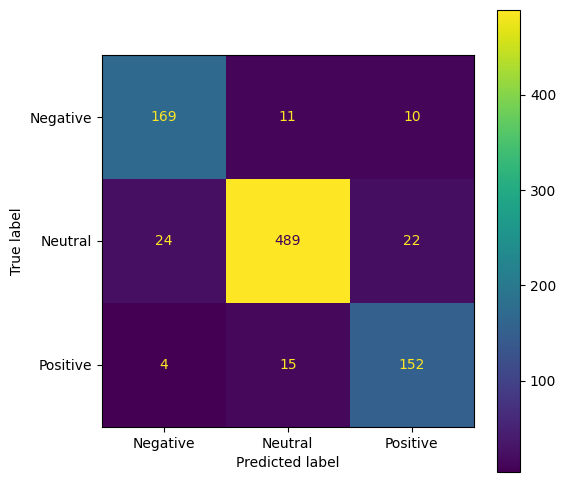

              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87       190
     Neutral       0.95      0.91      0.93       535
    Positive       0.83      0.89      0.86       171

    accuracy                           0.90       896
   macro avg       0.88      0.90      0.89       896
weighted avg       0.91      0.90      0.90       896



In [61]:
model_path = r'E:\Project\Repo_Classification\PolishTweetsClassification\results_No_processing_allegro\herbert-base-cased\checkpoint-1192'

tokenized_dataset = tokenized_datasets['No_processing']

# Load the tokenizer and model
model = BertForSequenceClassification.from_pretrained(model_path)
trainer = Trainer(
    model=model,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)


# Get predictions
predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Create and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Neutral', 'Positive']))

In [62]:
import torch.nn.functional as F
import numpy as np

# Get predictions (these are logits)
predictions = trainer.predict(tokenized_dataset["test"])
raw_logits = predictions.predictions

# Apply softmax to get probabilities
softmax_probs = F.softmax(torch.tensor(raw_logits), dim=1).numpy()

# Now you can:
# 1. Print probabilities for individual predictions
print("First 5 predictions with probabilities:")
for i in range(5):
    print(f"Example {i}:")
    print(f"Negative prob: {softmax_probs[i][0]:.4f}")
    print(f"Neutral prob: {softmax_probs[i][1]:.4f}")
    print(f"Positive prob: {softmax_probs[i][2]:.4f}")
    print(f"Predicted class: {np.argmax(softmax_probs[i])}")
    print()

# 2. Get average confidence scores
avg_confidence = np.mean(np.max(softmax_probs, axis=1))
print(f"Average confidence score: {avg_confidence:.4f}")

# 3. Find highly uncertain predictions (where max probability is below a threshold)
uncertainty_threshold = 0.7
uncertain_preds = np.where(np.max(softmax_probs, axis=1) < uncertainty_threshold)[0]
print(f"\nNumber of uncertain predictions: {len(uncertain_preds)}")


***** Running Prediction *****
  Num examples = 896
  Batch size = 8
100%|██████████| 112/112 [00:35<00:00,  3.14it/s]

First 5 predictions with probabilities:
Example 0:
Negative prob: 0.0585
Neutral prob: 0.9265
Positive prob: 0.0149
Predicted class: 1

Example 1:
Negative prob: 0.0070
Neutral prob: 0.9882
Positive prob: 0.0047
Predicted class: 1

Example 2:
Negative prob: 0.6083
Neutral prob: 0.3718
Positive prob: 0.0200
Predicted class: 0

Example 3:
Negative prob: 0.0054
Neutral prob: 0.9887
Positive prob: 0.0059
Predicted class: 1

Example 4:
Negative prob: 0.9544
Neutral prob: 0.0265
Positive prob: 0.0191
Predicted class: 0

Average confidence score: 0.9236

Number of uncertain predictions: 60


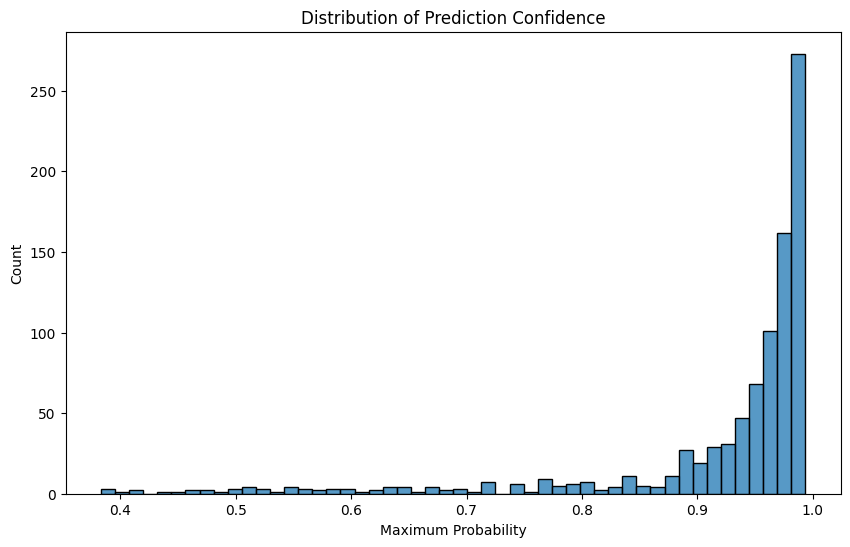

In [63]:
import seaborn as sns

# Plot distribution of maximum probabilities
plt.figure(figsize=(10, 6))
sns.histplot(np.max(softmax_probs, axis=1), bins=50)
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Maximum Probability')
plt.ylabel('Count')
plt.show()

In [64]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2088
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 896
    })
})

In [65]:
import torch.nn.functional as F
import numpy as np
import pandas as pd

# Get predictions and convert to probabilities
predictions = trainer.predict(tokenized_dataset["test"])
raw_logits = predictions.predictions
softmax_probs = F.softmax(torch.tensor(raw_logits), dim=1).numpy()

# Load original test dataset that contains the text
# You'll need to provide the original dataset that was used for tokenization

# Create a DataFrame with texts and probabilities
results_df = pd.DataFrame({
    'text': test_df['text'].values,  # assuming text column is named 'text'
    'true_label': true_labels,
    'predicted_label': np.argmax(softmax_probs, axis=1),
    'negative_prob': softmax_probs[:, 0],
    'neutral_prob': softmax_probs[:, 1],
    'positive_prob': softmax_probs[:, 2],
    'confidence': np.max(softmax_probs, axis=1)
})

# Function to get label name
def get_label_name(label_id):
    labels = ['Negative', 'Neutral', 'Positive']
    return labels[label_id]

# Add readable labels
results_df['true_label_name'] = results_df['true_label'].apply(get_label_name)
results_df['predicted_label_name'] = results_df['predicted_label'].apply(get_label_name)


# Show high confidence mistakes
confidence_threshold = 0.9
misclassified = results_df[
    (results_df['true_label'] != results_df['predicted_label']) & 
    (results_df['confidence'] > confidence_threshold)
]

print("\nHighly confident misclassifications:")
for idx, row in misclassified.head(100).iterrows():
    print("\n" + "="*100)
    print(f"Tweet: {row['text']}")
    print(f"True label: {row['true_label_name']}")
    print(f"Predicted (wrong): {row['predicted_label_name']}")
    print(f"Confidence: {row['confidence']:.4f}")

# Save detailed results to CSV
results_df.to_csv('predictions_analysis.csv', index=False)


***** Running Prediction *****
  Num examples = 896
  Batch size = 8
100%|██████████| 112/112 [00:34<00:00,  3.22it/s]


Highly confident misclassifications:

Tweet: @MarcinBanas3 @Felipe___666 @AdamAdam4949 Dla tego Allegro mogło dostać po dupie, a Orlenu nie wolno dotknąć. Bo pięknie rżnie takich jak ja. Niemiec 5,40, ja 6,78/l. By udziałowcy byli zadowoleni, szczególnie większościowi. To jest zorganizowana mafia. https://t.co/BTNYu8gwh4
True label: Neutral
Predicted (wrong): Negative
Confidence: 0.9161

Tweet: @Suilerua_ Pisałem, żeby trzymać to ccc
True label: Positive
Predicted (wrong): Neutral
Confidence: 0.9885

Tweet: Hello InPost @InPostPL od rana czekam na przesyłkę a tu jeszcze lepszy zong teraz się pokazał... Gratuluję organizacji pracy.... https://t.co/47mtmV00IC
True label: Negative
Predicted (wrong): Positive
Confidence: 0.9675

Tweet: @m_gdula @__Lewica Pan w ogóle nie rozumie na czym polega problem. CI którzy nie płacą i tak nie zapłacą a obciąży Pan dodatkowo taki Inpost. Ma Pan chociaż kawałem mózgu ? Bo ta propozycja sugeruje, że nie bardzo.
True label: Neutral
Predicted (wrong): Neg

In [66]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_samples = {
    "Index": misclassified_indices,
    "True Label": true_labels[misclassified_indices],
    "Predicted Label": predicted_labels[misclassified_indices],
    "Text": [tokenizer.decode(tokenized_dataset["test"]["input_ids"][i], skip_special_tokens=True) for i in misclassified_indices]
}
df_misclassified = pd.DataFrame(misclassified_samples)

In [67]:
df_misclassified.to_clipboard()

PyperclipWindowsException: Error calling OpenClipboard ([WinError 0] Operacja ukończona pomyślnie.)